In [1]:
import yaml

In [2]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [3]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [9]:
stream = open(
    '/disk/scratch/neuroglycerin/yaml_settings/replicate_8augreplicate_8aug_online.yaml')
string = stream.read()

In [12]:
import pylearn2.config.yaml_parse

You have to use the yaml imported into the `pylearn2.config.yaml_parse` namespace because it has to be initialised in there as follows:

In [13]:
pylearn2.config.yaml_parse.initialize()

Then, we can load a proxied version of the code, where nothing has been initialised yet and pull out the dataset.

In [15]:
proxied = pylearn2.config.yaml_parse.yaml.load(string)

In [19]:
proxied.keywords['dataset']

BaseProxy(callable=<class 'neukrill_net.image_directory_dataset.ListDataset'>, positionals=(), keywords={'run_settings_path': '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/run_settings/replicate_8aug.json', 'transformer': BaseProxy(callable=<class 'neukrill_net.augment.RandomAugment'>, positionals=(), keywords={'rotate': [0, 90, 180, 270], 'rotate_is_resizable': 0, 'normalise': {'mu': 0.957271277905, 'global_or_pixel': 'global', 'sigma': 0.142253264785}, 'flip': 1, 'units': 'float', 'resize': [48, 48]}, yaml_src="!obj:neukrill_net.augment.RandomAugment {units: 'float', rotate: [0, 90, 180, 270],\n  rotate_is_resizable: 0, flip: 1, resize: [48, 48], normalise: {global_or_pixel: 'global',\n    mu: 0.957271277905, sigma: 0.142253264785}}\n"), 'settings_path': '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/settings.json'}, yaml_src="!obj:neukrill_net.image_directory_dataset.ListDataset {transformer: !obj:neukrill_net.augment.RandomAugment {\n    units: 'float',

Then, we can modify this so that it'll force loading the dataset even though it expects to overwrite the run files.

In [21]:
proxdata = proxied.keywords['dataset']
proxdata.keywords['force'] = True

In [22]:
proxdata

BaseProxy(callable=<class 'neukrill_net.image_directory_dataset.ListDataset'>, positionals=(), keywords={'run_settings_path': '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/run_settings/replicate_8aug.json', 'transformer': BaseProxy(callable=<class 'neukrill_net.augment.RandomAugment'>, positionals=(), keywords={'rotate': [0, 90, 180, 270], 'rotate_is_resizable': 0, 'normalise': {'mu': 0.957271277905, 'global_or_pixel': 'global', 'sigma': 0.142253264785}, 'flip': 1, 'units': 'float', 'resize': [48, 48]}, yaml_src="!obj:neukrill_net.augment.RandomAugment {units: 'float', rotate: [0, 90, 180, 270],\n  rotate_is_resizable: 0, flip: 1, resize: [48, 48], normalise: {global_or_pixel: 'global',\n    mu: 0.957271277905, sigma: 0.142253264785}}\n"), 'force': True, 'settings_path': '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/settings.json'}, yaml_src="!obj:neukrill_net.image_directory_dataset.ListDataset {transformer: !obj:neukrill_net.augment.RandomAugment {\n    

Then we can use the intstantiate function to load the dataset:

In [23]:
dataset = pylearn2.config.yaml_parse._instantiate(proxdata)

Image
      I    : Image.Image   (z)
      II   : Image.Image   (z)
      III  : Image.Image   (z)
      IV   : Image.Image   (z)
      V    : Image.Image   (z)
      VI   : Image.Image   (z)
      VII  : Image.Image   (z)
      VIII : Image.Image   (z)
      IX   : Image.Image   (z)
      X    : Image.Image   (z)
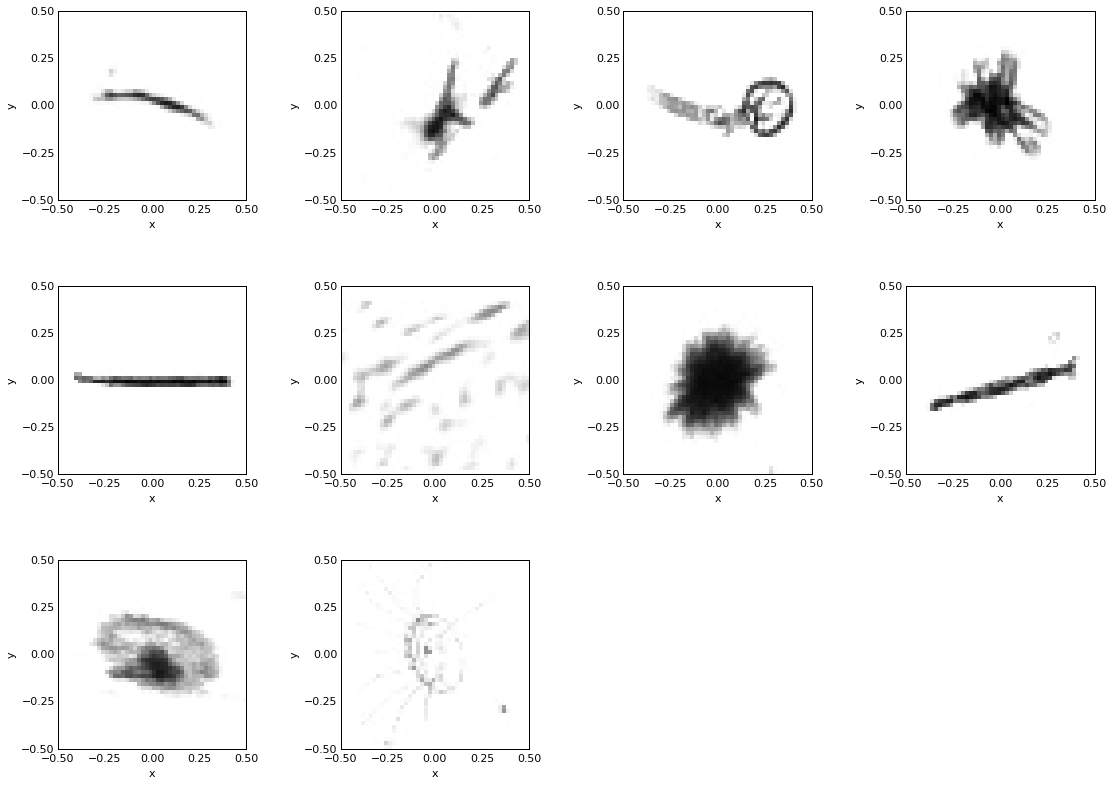

In [32]:
%opts Image style(cmap="gray")
# plot some images to show that it worked
i = dataset.iterator(mode='even_shuffled_sequential',batch_size=128)
b = i.next()
channels = None
for ex in range(10):
    if not channels:
        channels = hl.Image(b[0][ex,:].squeeze())
    else:
        channels += hl.Image(b[0][ex,:].squeeze())
channels

Checking input space
=======

We also want to know what kind of input space we're dealing with, because that varies between models as well.

In [33]:
proxied.keywords['model'].keywords['input_space'].keywords['axes']

['b', 0, 1, 'c']

Then, we can just use an if statement to check for the two cases.

Using an iterator
======

Now I'm probably familiar enough with how the iterators are supposed to work I can use an iterator to loop over the dataset and generate minibatches for prediction rather than the hacky way we're doing it at the moment.

Unfortunately, it does mean we'll have to pull the data specs out of the cost object as in the Transformer Dataset notebook.

In [36]:
pcost = proxied.keywords['algorithm'].keywords['cost']

In [37]:
cost = pylearn2.config.yaml_parse._instantiate(pcost)

In [38]:
model = pylearn2.utils.serial.load("/disk/scratch/neuroglycerin/models/replicate_8aug.pkl")

In [41]:
data_specs = cost.get_data_specs(model)
data_specs

(CompositeSpace(Conv2DSpace(shape=(48, 48), num_channels=1, axes=('b', 0, 1, 'c'), dtype=float32), VectorSpace(dim=121, dtype=float32)),
 ('features', 'targets'))

In [ ]:
alg.cost

In [43]:
x = range(10)

In [44]:
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Collapsing predictions
========

Now we have a big stacked array of predictions, it's just a matter of collapsing the predictions into a single array.

In [53]:
x = np.random.randn(100,10)

In [57]:
np.mean(x,axis=0).shape

(10,)